In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
df=pd.read_csv(r"C:/Users/User/Desktop/train.csv")

In [43]:
df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


<Axes: xlabel='marital', ylabel='count'>

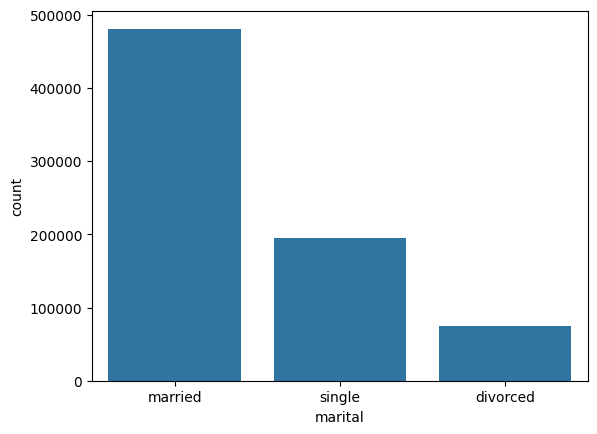

In [45]:
sns.countplot(data=df,x="marital")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'technician'),
  Text(1, 0, 'blue-collar'),
  Text(2, 0, 'student'),
  Text(3, 0, 'admin.'),
  Text(4, 0, 'management'),
  Text(5, 0, 'entrepreneur'),
  Text(6, 0, 'self-employed'),
  Text(7, 0, 'unknown'),
  Text(8, 0, 'services'),
  Text(9, 0, 'retired'),
  Text(10, 0, 'housemaid'),
  Text(11, 0, 'unemployed')])

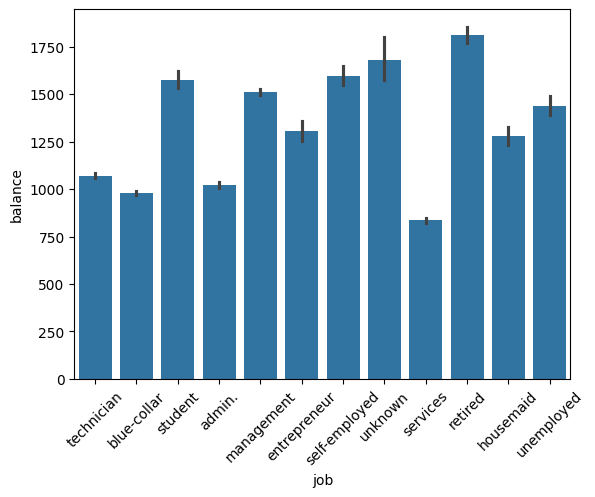

In [46]:
sns.barplot(data=df,x="job",y="balance")
plt.xticks(rotation=45)

<Axes: >

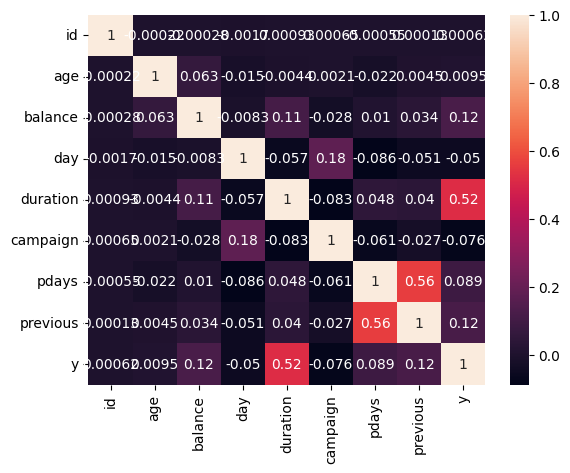

In [47]:
num_col=df.select_dtypes(include=["int64"]).columns
s=df[num_col].corr()
sns.heatmap(s,annot=True)

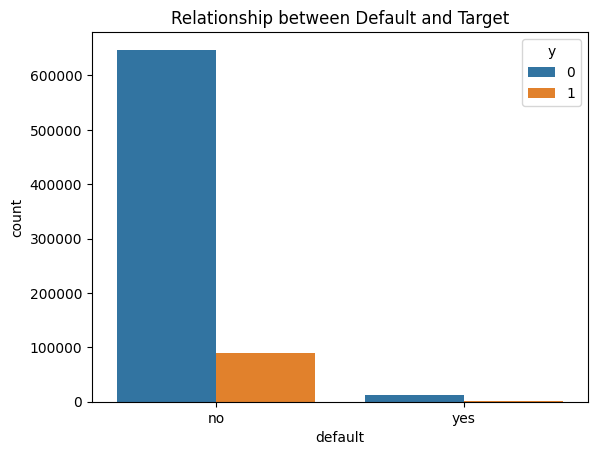

In [48]:
sns.countplot(data=df, x='default', hue='y')
plt.title('Relationship between Default and Target')
plt.show()


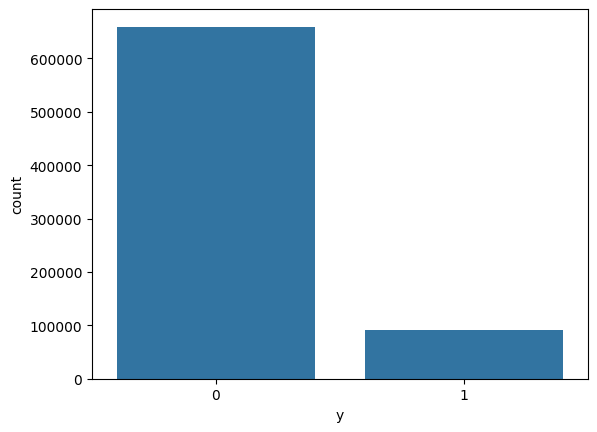

In [49]:
sns.countplot(x='y', data=df)
plt.show()


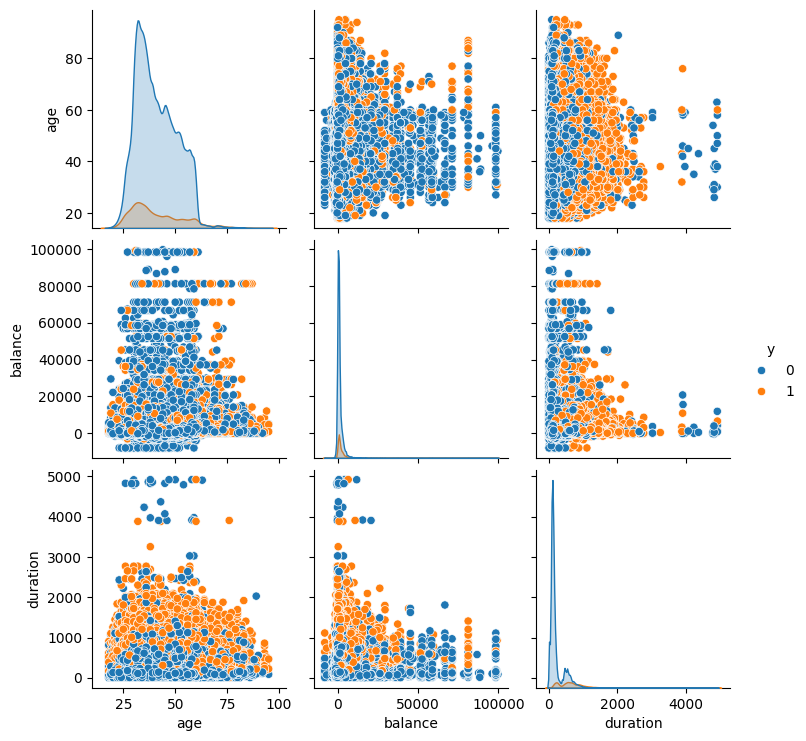

In [50]:
sns.pairplot(df, hue='y', vars=['age','balance','duration'])
plt.show()


In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split


train_df = pd.read_csv(r"C:/Users/User/Desktop/train.csv")
test_df = pd.read_csv(r"C:/Users/User/Desktop/test.csv")
sample_submission = pd.read_csv(r"C:/Users/User/Desktop/sample_submission.csv")

X = train_df.drop(columns=["y"])
y = train_df["y"]

categorical_features = ['job', 'marital', 'education', 'default',
'housing', 'loan', 'contact', 'month', 'poutcome']


X_train, X_val, y_train, y_val = train_test_split(
 X, y, test_size=0.2, random_state=42, stratify=y
)


def objective(trial):
    params = {
       "iterations": 200,  
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 3, 8),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "eval_metric": "Accuracy",
        "verbose": 0,
        "early_stopping_rounds": 30
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
      cat_features=categorical_features, verbose=0)
    preds = model.predict(X_val)
    return 1 - accuracy_score(y_val, preds)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5) 

print("best_params", study.best_params)



best_params = study.best_params
best_params["iterations"] = 1000 
best_params["verbose"] = 10

final_model = CatBoostClassifier(**best_params)
final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]),
  cat_features=categorical_features)


y_val_pred = final_model.predict(X_val)

accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average="macro")
recall = recall_score(y_val, y_val_pred, average="macro")
f1 = f1_score(y_val, y_val_pred, average="macro")
cm = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1-score: {f1}")
print("Validation Confusion Matrix:")
print(cm)
print("\nClassification Report:\n", report)




[I 2025-10-03 19:33:20,495] A new study created in memory with name: no-name-802ef47e-a370-437f-b4d4-e2d0fd8b1d35
[I 2025-10-03 19:34:40,823] Trial 0 finished with value: 0.07789999999999997 and parameters: {'learning_rate': 0.011876157488087468, 'depth': 6, 'subsample': 0.702622106917975, 'colsample_bylevel': 0.6550018060606828}. Best is trial 0 with value: 0.07789999999999997.
[I 2025-10-03 19:35:34,703] Trial 1 finished with value: 0.07777333333333336 and parameters: {'learning_rate': 0.03575717332237899, 'depth': 3, 'subsample': 0.671961455487934, 'colsample_bylevel': 0.8551183501387689}. Best is trial 1 with value: 0.07777333333333336.
[I 2025-10-03 19:35:55,077] Trial 2 finished with value: 0.08922666666666668 and parameters: {'learning_rate': 0.0016760153136714667, 'depth': 6, 'subsample': 0.8595496527192201, 'colsample_bylevel': 0.6323300392985849}. Best is trial 1 with value: 0.07777333333333336.
[I 2025-10-03 19:37:08,761] Trial 3 finished with value: 0.07554666666666665 and 

أفضل بارامترات: {'learning_rate': 0.018301504210554632, 'depth': 6, 'subsample': 0.6358679795451732, 'colsample_bylevel': 0.8675157615284246}
0:	learn: 0.6625715	total: 366ms	remaining: 6m 6s
10:	learn: 0.4403917	total: 3.98s	remaining: 5m 58s
20:	learn: 0.3267834	total: 7.47s	remaining: 5m 48s
30:	learn: 0.2681276	total: 10.9s	remaining: 5m 41s
40:	learn: 0.2365224	total: 14.3s	remaining: 5m 33s
50:	learn: 0.2185177	total: 17.5s	remaining: 5m 25s
60:	learn: 0.2068257	total: 20.8s	remaining: 5m 19s
70:	learn: 0.1983358	total: 24s	remaining: 5m 13s
80:	learn: 0.1923188	total: 27.5s	remaining: 5m 11s
90:	learn: 0.1878857	total: 31s	remaining: 5m 9s
100:	learn: 0.1848516	total: 34.4s	remaining: 5m 6s
110:	learn: 0.1823250	total: 38s	remaining: 5m 4s
120:	learn: 0.1804160	total: 41.5s	remaining: 5m 1s
130:	learn: 0.1787312	total: 45.1s	remaining: 4m 59s
140:	learn: 0.1772268	total: 48.6s	remaining: 4m 56s
150:	learn: 0.1758635	total: 52.2s	remaining: 4m 53s
160:	learn: 0.1745375	total: 55.